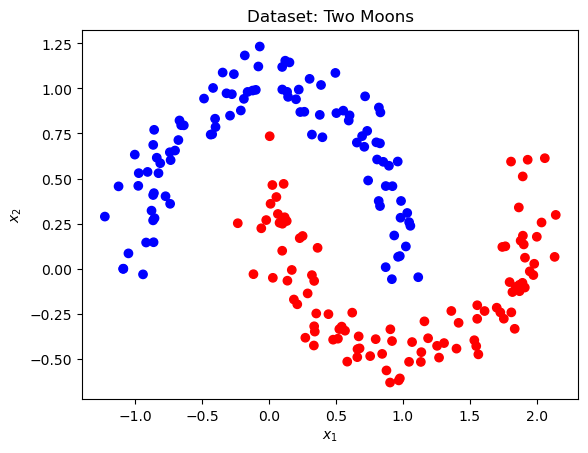

In [18]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generar datos no linealmente separables
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

# Escalar para que los datos queden en un rango manejable (usado en codificación)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Ploteamos los datos
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
plt.title("Dataset: Two Moons")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

In [42]:
import pennylane as qml
import numpy as np

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

def angle_embedding(x):
    for i in range(len(x)):
        qml.RY(x[i], wires=i)

def hardware_efficient_ansatz(params):
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    qml.CNOT(wires=[0, 1])
    for i in range(n_qubits):
        qml.RZ(params[n_qubits + i], wires=i)

@qml.qnode(dev)
def circuit(x, params):
    angle_embedding(x)
    hardware_efficient_ansatz(params)
    return qml.expval(qml.PauliX(0) @ qml.PauliY(0))  # Este valor será usado para clasificación


In [43]:
def sigmoid(x):
    return 1 / (1 + np.exp(- 4 * x))

def cost_BCE(params, X, y):
    loss = 0
    for i in range(len(X)):
        pred = circuit(X[i], params)
        prob = sigmoid(pred)  # mapear -1,1 → 0,1
        prob = np.clip(prob, 1e-6, 1-1e-6)  # evitar log(0)
        loss += -y[i]*np.log(prob) - (1 - y[i])*np.log(1 - prob)
    return loss / len(X)


In [44]:
import pennylane.optimize as opt
from scipy.optimize import minimize

params = np.random.uniform(0, 2*np.pi, size=2*n_qubits)
optimizer = opt.AdamOptimizer(stepsize=0.1)


min_result = minimize(cost_BCE, params, args=(X_train, y_train), method="COBYLA")

print(min_result)
epochs = 50

"""
for epoch in range(epochs):
    params = optimizer.step(lambda p: cost_BCE(p, X_train, y_train), params)
    if epoch % 10 == 0:
        loss = cost_BCE(params, X_train, y_train)
        print(f"Epoch {epoch}: Loss = {loss:.4f}")
"""

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.3897867506130167
       x: [ 1.620e+00  1.182e-01  1.570e+00  4.840e+00]
    nfev: 142
   maxcv: 0.0


'\nfor epoch in range(epochs):\n    params = optimizer.step(lambda p: cost_BCE(p, X_train, y_train), params)\n    if epoch % 10 == 0:\n        loss = cost_BCE(params, X_train, y_train)\n        print(f"Epoch {epoch}: Loss = {loss:.4f}")\n'

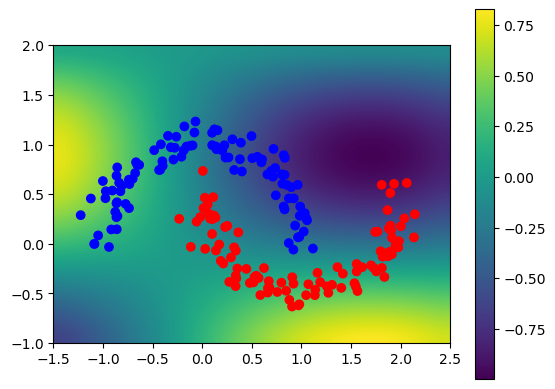

In [46]:
opt_params = min_result.x

resolution = 20

x_map = np.linspace(-1.5, 2.5, resolution)
y_map = np.linspace(-1, 2, resolution)

z_map = np.zeros((resolution, resolution))

for i in range(resolution):
    for j in range(resolution):
        z_map[i, j] = circuit((x_map[i], y_map[j]), opt_params)

plt.imshow(z_map, extent=[-1.5, 2.5, -1, 2], interpolation="bicubic")
plt.colorbar()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr")
